In [ ]:
%pip install --upgrade --quiet fastbook python-dotenv

import fastbook
fastbook.setup_book()

In [7]:
from fastbook import *
from fastai.vision.widgets import *

### 1. Galaxy Classifier

A naive Galaxy Classifier to classify images of the galaxies:
- andromeda
- cigar m82
- ngc 1300
- sombrero
- tadpole
- whirlpool

The purpose of this notebook is to illustrate how to create a custom dataset, fine tune a vision model (`ResNet34`) using [fast.ai](https://docs.fast.ai/), and use it for inference.

### 2. Create the Galaxies Dataset

In [8]:
import os
from dotenv import load_dotenv

The goal of this botanic project is to classify bulbs across `hyacinths`, `gladiolus`, `lilies`, and `tulips`. 

To download images we use Bing Image Search. Sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. The API key (free up to 1k queries/month, each query can download 150 images) can be added as an environment variables to the `.env` file.

In [9]:
load_dotenv()
key = os.getenv('AZURE_SEARCH_KEY')

> **Note that by adding the Galaxy code, Bing will retrieve better quality pictures.**

In [15]:
_searches = 'm31 andromeda', 'm33 triangulum', 'm81 bode', 'm82 cigar', 'ngc 1300', 'm104 sombrero', 'm51 whirlpool'
path = Path('galaxies')

if not path.exists():
    path.mkdir()
    for o in _searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} galaxy', max_images=150)
        download_images(dest, urls=results.attrgot('contentUrl'))

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [16]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

164

### 3. Train the Model

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

In [17]:
?RandomResizedCrop

Init signature:
RandomResizedCrop(
    self,
    size: 'int | tuple',
    min_scale: 'float' = 0.08,
    ratio=(0.75, 1.3333333333333333),
    resamples=(<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>),
    val_xtra: 'float' = 0.14,
    max_scale: 'float' = 1.0,
    **kwargs,
)
Docstring:      Picks a random scaled crop of an image and resize it to `size`
File:           /usr/local/lib/python3.9/dist-packages/fastai/vision/augment.py
Type:           _TfmMeta
Subclasses:     


In [33]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.85, max_scale=1.25),
    batch_tfms=aug_transforms()
).dataloaders(path) # During training, PyTorch iterates tru dataloaders to get a bunch of data

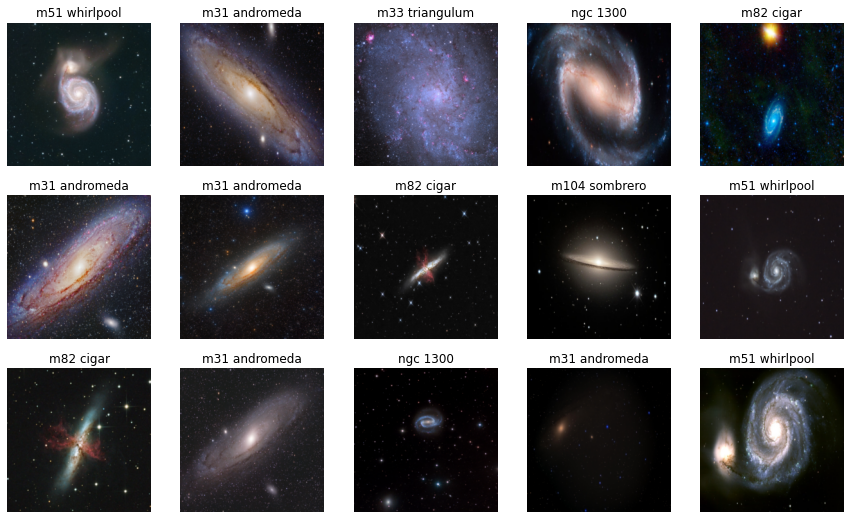

In [19]:
# show a batch of data and labels
dls.valid.show_batch(max_n=15, nrows=3)

#### Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

### Transfer Learning from ResNet50

In [34]:
# learners combines the data (dls) and the model (the actual NN function) to train the model
# https://timm.fast.ai/
# resnet34 is a pre-trained model whose weights are already available
learn = vision_learner(dls, resnet50, metrics=accuracy)
# Adjust the pre-trained model
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.757206,0.907814,0.733728,00:24


epoch,train_loss,valid_loss,accuracy,time
0,0.596668,0.463357,0.881657,00:25
1,0.403594,0.246368,0.893491,00:24
2,0.299651,0.278404,0.899408,00:21


We can see that after 3 epochs, 90% of the predictions in the validation set are correct.

### Confusion Matrix

Lets visualize where are the prediction errors by using a confusion matrix:

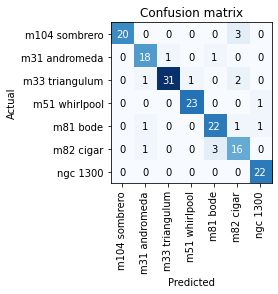

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows us to view the results of a model. It is calculated using the validation set. 

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that are labeled incorrectly), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their loss.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. plot_top_losses shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

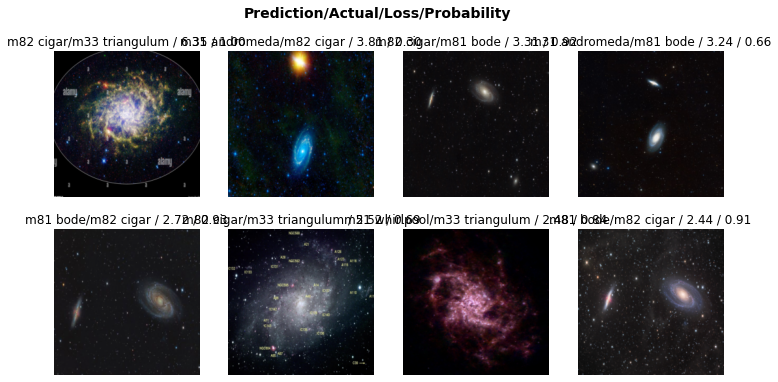

In [36]:
interp.plot_top_losses(8, nrows=2)

Now it would be appropiate to clean the data, fastai provides `ImageClassifierCleaner` for this purpose.

In [ ]:
#cleaner = ImageClassifierCleaner(learn)
#cleaner

### 4. Using the Model for Inference

A model consists of two parts: the architecture and the trained parameters. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the export method.

This method even saves the definition of how to create your DataLoaders. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set DataLoader for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call export, fastai will save a file called "export.pkl":

In [37]:
learn.export('galaxies.pkl')

In [38]:
learn_inf = load_learner('galaxies.pkl')

`learn_inf.predict` returns the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [39]:
t = learn_inf.predict('images/andromeda.jpg')

In [40]:
categories = learn_inf.dls.vocab
probs = torch.softmax(t[2], dim=0)

dict(zip(categories, map(float, probs)))

{'m104 sombrero': 0.11470161378383636,
 'm31 andromeda': 0.3117896318435669,
 'm33 triangulum': 0.11470220983028412,
 'm51 whirlpool': 0.11470161378383636,
 'm81 bode': 0.11470162868499756,
 'm82 cigar': 0.11470161378383636,
 'ngc 1300': 0.11470161378383636}